In [6]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [7]:
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import requests
import glob as glob

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [8]:
SEED_VALUE = 41

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [9]:



def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")


unzip(zip_file='/content/drive/MyDrive/george-data/george_test_task.zip')

Extracted all


In [11]:
data = tf.keras.utils.image_dataset_from_directory('/content/data')

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

# Scale Data
data = data.map(lambda x,y: (x/255, y))

# Split Data
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Found 5600 files belonging to 2 classes.


In [12]:
# @dataclass(frozen=True)
# class DatasetConfig:
#     NUM_CLASSES: int = 43
#     IMG_HEIGHT:  int = 224
#     IMG_WIDTH:   int = 224
#     CHANNELS:    int = 3

#     DATA_ROOT_TRAIN = train
#     DATA_ROOT_VALID = val
#     DATA_ROOT_TEST = test

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 101
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8

In [13]:
# train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
#                                              batch_size=TrainingConfig.BATCH_SIZE,
#                                              shuffle=True,
#                                              seed=SEED_VALUE,
#                                              label_mode='int',        # Use integer encoding
#                                              image_size=(224, 224),
#                                             )

# valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
#                                              batch_size=TrainingConfig.BATCH_SIZE,
#                                              shuffle=True,
#                                              seed=SEED_VALUE,
#                                              label_mode='int',        # Use integer encoding
#                                              image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
#                                             )

Found 5600 files belonging to 2 classes.
Using 4480 files for training.


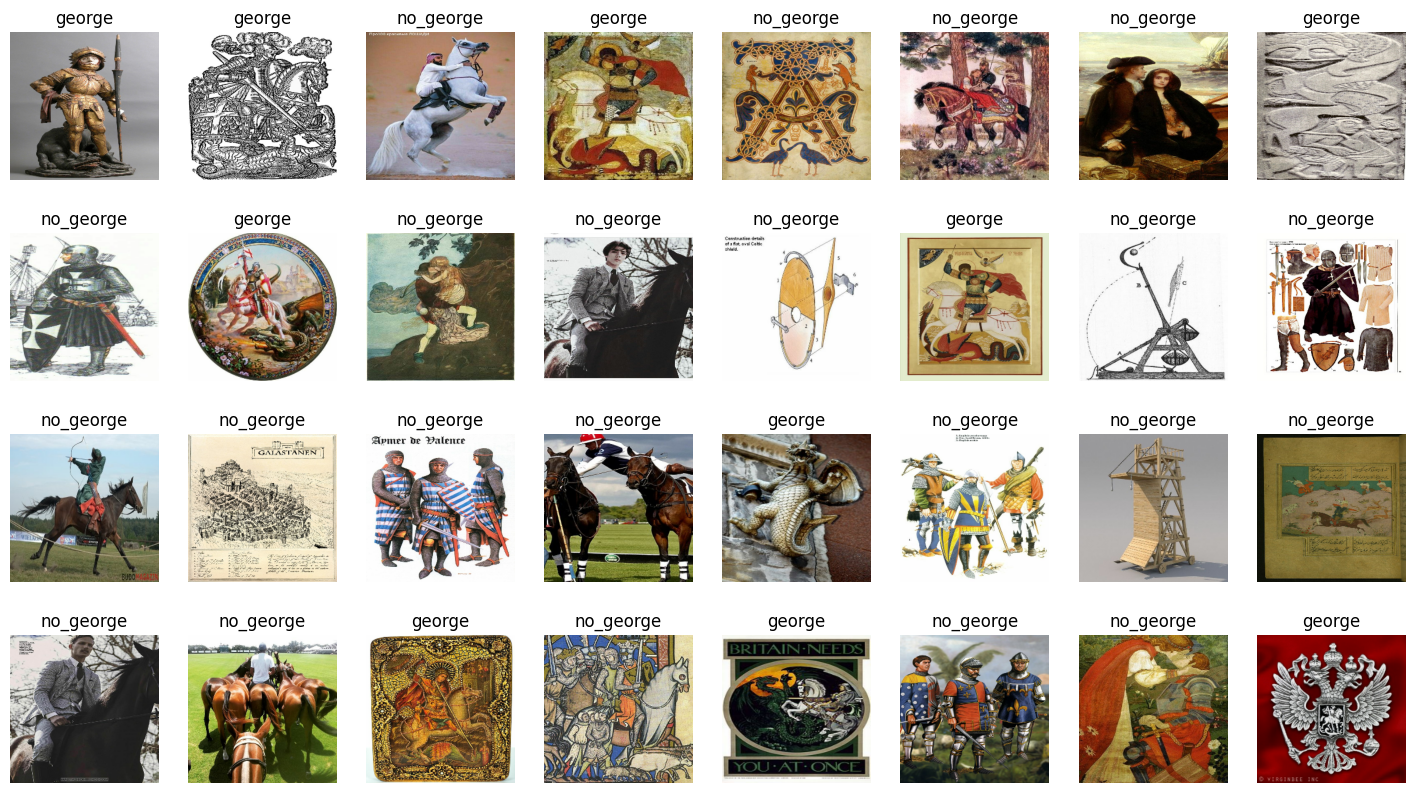

In [14]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/data',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=42
)

class_names = train_dataset.class_names

plt.figure(figsize=(18,10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1):

    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

In [15]:
tf.keras.applications.vgg16.VGG16(include_top=True,
                                  weights='imagenet',
                                  input_tensor=None,
                                  input_shape=None,
                                  pooling=None,
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )

553467096/553467096 [==============================] - 25s 0us/step


In [16]:
# Specify the model input shape.
input_shape = (256, 256, 3)

print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
print(vgg16_conv_base.summary())

Loading model with ImageNet weights...
58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                       

In [17]:
# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below).
vgg16_conv_base.trainable = True

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg16_conv_base.layers)

# Freeze the initial layers in the convolutional base.
for model_layer in vgg16_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
print("\n")

print(vgg16_conv_base.summary())

FREEZING LAYER: <keras.engine.input_layer.InputLayer object at 0x7d4bd174dc30>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7d4bd174f520>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7d4bd174d060>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7d4bd1719570>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7d4bd171a470>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7d4bd1702a70>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7d4bd16eabf0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7d4bd16ebe80>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7d4bd156d1b0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7d4bd15bf8e0>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7d4bd1732ef0>


Configured to fine tune the last 8 convolutional layers...

In [18]:
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.applications.vgg16.preprocess_input(inputs)

x = vgg16_conv_base(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(TrainingConfig.DROPOUT)(x)

# The final `Dense` layer with the number of classes.
outputs = layers.Dense(2, activation='softmax')(x)

# The final model.
model_vgg16_finetune = keras.Model(inputs, outputs)

print(model_vgg16_finetune.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                             

In [19]:
# Use this for integer encoded labels.
model_vgg16_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [ ]:
# Train the Model.
training_results = model_vgg16_finetune.fit(train,
                                            epochs=10,
                                            validation_data=val,
                                           )

Epoch 1/10
122/122 [==============================] - ETA: 0s - loss: 0.7295 - accuracy: 0.5694